# Structure of this file
---

## 1. Read Wind Data
    i. Determine coordinates (lat, lon, time)
    ii. Trim to study region
			
			
## 2. Read Ship Data
	i. Average over N minutes
			
			
## 3. Map wind data to ship
	i. Interpolate
	ii. Calculate N-day average
			
			
## 4. Read CTD Data
	i. Define and Calculate MLD
	ii. Map MLD to ship data
			
			
## 5. Preliminary Plots
---

### Introduction
__First__ we need to load up the relevent libraries and define any helper functions.

In [2]:
## Install the package if needed:
install.packages('ncdf4', repos='http://cran.us.r-project.org')

## Load the relevent packages
library(ncdf4)  # For reading in the NCEP wind fields
#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
#library(fields)  # For doing the bilinear interpolation of the wind data to ship position.
#library(RCurl)
#library(rNOMADS)  # For reading grib2 data files (NOMADS data for instance)
#library(rGDAL)  #

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='US/Pacific') {
    as.POSIXct(as.Date(x,origin="1899-12-30", tz=tz))
}

Warning message in install.packages("ncdf4", repos = "http://cran.us.r-project.org"):
“installation of package ‘ncdf4’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


ERROR: Error in library(ncdf4): there is no package called ‘ncdf4’


---
# 1. Reading in the NCEP wind data (.nc files)
This section will load in the wind data from two .nc files (u and v components). Once loaded, we need to determine how the x,y,z dimentions of the data matrix correspond to the lat, lon, time dimensions--this is done easily from the metadata contained within the file. Nothing else is required to complete this section.

Wind data is available from a variety of sources with variable resolution (spatial and temporal) and difficulty in integrating with this script (easy to import .nc to custom binary formats).

*  ~0.3 degree, 3hr, .nc format (N. America only) -- [NARR](https://www.esrl.noaa.gov/psd/data/gridded/data.narr.monolevel.html)
* 2.5 degree, 6hr, .nc format -- [NCEP](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surface.html)
* 0.25 degree, 6hr, .nc format (inc. cloud cover) -- [NCSS](https://www.ncei.noaa.gov/thredds/ncss/uv/6h_agg_rt/Preliminary_Aggregation_best.ncd/dataset.html)
* 0.25 degree, hourly, .D binary format -- [NAVGEM](ftp://ftp.hycom.org/datasets/force/NAVGEM/navgem1.4_0.281c/1hourly/)

In [ ]:
## If there are saved datasets, then run this to load them

load('./RStates/wind.lat.rdata')
load('./RStates/wind.lon.rdata')
load('./RStates/wind.ncep.rdata')
load('./RStates/time.actual.rdata')

In [3]:
## Load all the data files and check their format and naming scheme.

u.nc = nc_open('C:/Users/Tom/Downloads/uwnd.10m.2017.nc', write=FALSE)
v.nc = nc_open('C:/Users/Tom/Downloads/vwnd.10m.2017.nc', write=FALSE)

In [4]:
## Use the file metadata to populate ranges and coordinate mappings
u.nc

File C:/Users/Tom/Downloads/uwnd.10m.2017.nc (NC_FORMAT_NETCDF4_CLASSIC):

     4 variables (excluding dimension variables):
        float lat[x,y]   
            axis: Y
            coordinate_defines: point
            long_name: Latitude
            standard_name: latitude
            units: degrees_north
        float lon[x,y]   
            axis: X
            coordinate_defines: point
            long_name: Longitude
            standard_name: longitude
            units: degrees_east
        int Lambert_Conformal[]   
            false_easting: 5632642.22547
            false_northing: 4612545.65137
            grid_mapping_name: lambert_conformal_conic
            latitude_of_projection_origin: 50
            longitude_of_central_meridian: -107
            standard_parallel: 50
             standard_parallel: 50
        float uwnd[x,y,time]   
            GRIB_id: 33
            GRIB_name: UGRD
            _FillValue: 9.96920996838687e+36
            coordinates: lat lon
      

In [5]:
## Setup the metadata 
time.bounds = c(1902192, 1906533)  # set based on file description above

## Load the data into u,v, lat, lon
wind.u = ncvar_get(u.nc, varid = 'uwnd')
wind.v = ncvar_get(v.nc, varid = 'vwnd')
wind.lat = ncvar_get(u.nc, varid = 'lat')
wind.lon = ncvar_get(u.nc, varid = 'lon')
#wind.lat = seq(88.5419998168945, 88.5419998168945, length.out=94)
#wind.lon = seq(0, 358.125, length.out=192)

dims = dim(wind.u)

## Calculate the actual times
time.actual = seq(time.bounds[1]*3600, time.bounds[2]*3600, length.out = dims[3])
time.actual = as.POSIXct(time.actual, origin='1800-01-01 00:00:00')  # orgin is in the file metadata above

## Check on time format/range
summary(time.actual)

                 Min.               1st Qu.                Median 
"2016-12-31 19:00:00" "2017-02-15 00:15:00" "2017-04-01 06:30:00" 
                 Mean               3rd Qu.                  Max. 
"2017-04-01 06:30:00" "2017-05-16 11:45:00" "2017-06-30 17:00:00" 

In [6]:
## Close the .nc files
nc_close(u.nc)
nc_close(v.nc)

### Flatten the lat/lon dimensions
Instead of sticking with the (x, y) -> lat (or longitude) coordinate mapping setup, let's flatten it out to make a list so that we have:

`i -> lat
i -> lon
i -> wind(t)`   --- Wind is a function of time at every location

Therefore we can simply the x-y grid to i = 1,2,3,4,5,6,7,8,..., x*y

In [7]:
## Calculate wind speed & Flatten
wind.ncep = array(NA, dim=c(dim(wind.u)[1] * dim(wind.u)[2], dim(wind.u)[3]))
for (i in 1:dim(wind.u)[3]) {
    wind.ncep[,i] = sqrt(as.numeric(wind.u[,,i]^2 + wind.v[,,i]^2))
}

## Flatten the lat and lon arrays as well
wind.lat = as.numeric(wind.lat)
wind.lom = as.numeric(wind.lon)

## Free memory
rm('wind.u')
rm('wind.v')
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,553302,29.6,940480,50.3,940480,50.3
Vcells,141199995,1077.3,582244552,4442.2,606368204,4626.3


### Trim the data
Take the time now to trim the data  to a more reasonable domain to speed up later computations (looping is expensive).

In [8]:
## First, check the domains of the data
print(paste('The minimum and maximum latitude in the NCEP data is', min(wind.lat), max(wind.lat)))
print(paste('The minimum and maximum longitude in the NCEP data is', min(wind.lon), max(wind.lon)))
print(paste('The minimum date in the NCEP data is', min(time.actual)))
print(paste('The minimum date in the NCEP data is', max(time.actual)))

[1] "The minimum and maximum latitude in the NCEP data is 0.897944986820221 85.3325500488281"
[1] "The minimum and maximum longitude in the NCEP data is -179.99690246582 179.992797851562"
[1] "The minimum date in the NCEP data is 2016-12-31 19:00:00"
[1] "The minimum date in the NCEP data is 2017-06-30 17:00:00"


In [9]:
## First set some generic bounds
lats = c(30, 40)
lons = c(-126, -118)

## Calcualte which entries should be kept (latitude)
keep.lat = wind.lat > lats[1] & wind.lat < lats[2] # Which col to keep
keep.lon = wind.lon > lons[1] & wind.lon < lons[2] # Which row to keep
keepers = keep.lat & keep.lon

## update all required variables
before = length(wind.ncep)

wind.lat = wind.lat[keepers]
wind.lon = wind.lon[keepers]

wind.ncep = wind.ncep[keepers, ]

print(paste("This cut removed", 100-length(wind.ncep)/before*100, '% of the data.'))

[1] "This cut removed 99.1486764660246 % of the data."


In [10]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,557798,29.8,940480,50.3,940480,50.3
Vcells,2370429,18.1,465795641,3553.8,606368204,4626.3


#### A good point to save

In [12]:
## Save wind data here -- can reload directly
save(wind.lat, file = './RStates/wind.lat.rdata')
save(wind.lon, file = './RStates/wind.lon.rdata')
save(wind.ncep, file = './RStates/wind.ncep.rdata')
save(time.actual, file = './RStates/time.actual.rdata')
write.xlsx(time.actual, file='./Input Data/Wind data - list of times.xlsx')

---
# 2. Load and prepare ship data
This section deals with the loading of the met-merge data. Once loaded and the structure is verified, a 2 minute average is taken for all parameters. Once completed, the next section will add the NCEP wind data and MLD to the data frame.The file structure which this script is looking for is as follows where Vars are in any order but with the proper abbreviations.

``Datetime  Var1   Var2  Var3 ...``

Variable Descriptions and Abbreviations
* __DT -- Date Time__
* __TW -- True Wind__
* TI  -- Wind Dir
* __LA -- Latitude__
* __LO -- Longitude__
* __AT -- Atm Temp__
* __BP -- Pressure__
* PA -- PAR
* __TT (TT2*)  -- Water Temp__
* __SA -- Salinity__
* __OS -- Oxygen__
* FL -- Fluorometer
* BT -- Bottom Depth

___NB___: Bold identies required columns while the others are used for additional analyses.

In [ ]:
## Load the data if already run:

load('./RStates/ship.avg.rdata')

In [21]:
## Load the xlsx file
ship.data = read.xlsx('../Met-data - merged/merge 063100702-corrected.xlsx', )

## Trim data to the following columns:
keep = c('DT', 'TW', 'TI', 'LA', 'LO', 'AT', 'BP', 'PA', 'TT', 'SA', 'OS', 'FL', 'BT')
# This call finds which columns match the names in keep and keeps them.
ship.data = ship.data[, which(names(ship.data) %in% keep)]

ship.data$DT = conv_excel_time(ship.data$DT) # Convert excel datetime numbers to actual datetimes.
ship.data$TW = ship.data$TW * 0.942  # Calculated from Thomas et al.

## Convert all columns (except date/time to numeric)
for (i in 2:ncol(ship.data)) {
    ship.data[,i] = as.numeric(ship.data[,i])
}

## Check that it loaded properly/correct data type (num)
print(paste('Do the number of names in keep match the number of columns now?', ncol(ship.data) == length(keep)))
str(ship.data)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

[1] "Do the number of names in keep match the number of columns now? FALSE"
'data.frame':	186490 obs. of  15 variables:
 $ DT  : POSIXct, format: "2017-05-30 20:01:00" "2017-05-30 20:01:00" ...
 $ TW  : num  2.54 2.17 2.83 3.01 3.01 ...
 $ TI  : num  209 214 216 224 226 ...
 $ TT  : num  19.4 19.4 19.4 19.4 19.4 ...
 $ SA  : num  33.2 33.2 33.2 33.2 33.2 ...
 $ OS  : num  5 5 5 5 5 ...
 $ FL  : num  0.079 0.08 0.077 0.076 0.076 0.077 0.076 0.076 0.076 0.074 ...
 $ AT  : num  16.7 16.7 16.7 16.8 16.8 ...
 $ BP  : num  1010 1010 1010 1010 1010 ...
 $ PA  : num  925 930 918 915 913 ...
 $ SA.1: num  33.2 33.2 33.2 33.2 33.2 ...
 $ OS.1: num  5 5 5 5 5 ...
 $ FL.1: num  0.079 0.08 0.077 0.076 0.076 0.077 0.076 0.076 0.076 0.074 ...
 $ LA  : num  32.7 32.7 32.7 32.7 32.7 ...
 $ LO  : num  -117 -117 -117 -117 -117 ...


#### Remove bad wind data
Here we simply remove the rows there wind speed is less than zero (TW < 0). We also report the number of rows affected (should be a relatively small amount).

In [22]:
bad.wind = which(ship.data$TW < 0)
length(bad.wind)

## Remove bad wind entries
ship.data = ship.data[-bad.wind,]

[1] 618

### The N minute average:
1. Start with the first row, set ___current.time___ to that row's time
2. Find all rows with times >= to the current time
3. Remove all rows with times more than N minutes away from the ___current.time___.
4. Take the column average of those rows and replace the current row.
5. Remove all the other rows
6. Repeat process on the next row.

In [23]:
### N Minute Averaging section
avg.length = 10  # minutes to avg

before = nrow(ship.data)
i = 1
nc = ncol(ship.data)

while (i < nrow(ship.data)) {  # Loop through each row in ship.data
    current.time = ship.data$DT[i]
    
    ## Determine which rows are within N minutes of the current row and average the values together
    in.range = which(ship.data$DT[1:(i+100)] >= current.time & difftime(ship.data$DT[1:(i+100)], current.time, units='mins') < avg.length)
    ship.data[i, 2:nc] = apply(ship.data[in.range, 2:nc], 2, mean)
    
    ## Remove all rows used to make average except for row i
    in.range = in.range[in.range != i]
    ship.data = ship.data[-in.range,]
    i = i + 1
}

print(paste('The number of rows before was', before, 'and now there are', nrow(ship.data)))

[1] "The number of rows before was 185872 and now there are 4619"


#### A good point to save

In [24]:
## Save point after loading ship data and averaging. 
save(ship.data, file='./RStates/ship.avg.rdata')
write.xlsx(ship.data, file='./Input Data/Shipdata - Averaged.xlsx')

gc() # Free up memory

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,657857,35.2,1812793,96.9,9878615,527.6
Vcells,19623983,149.8,53275371,406.5,606368204,4626.3


---
# 3. Determine MLD
This section reads in the CTD downcast files and identifies the 0.03 density change to calculate the MLD. THe MLD is then linearly interpolated onto the ship's track.

In [ ]:
load('./RStates/ship.avg.wind.mld.rdata')

In [29]:
## Read in the data files and convert the excel time
ctd.log = read.xlsx('./Raw Data/CTD/DataZoo - P1706 CTD Cast Log.xlsx', sheet = 'Data')
ctd.data = read.xlsx('./Raw Data/CTD/DataZoo - P1706 CTD Downcast Data.xlsx')

str(ctd.data)

'data.frame':	41780 obs. of  34 variables:
 $ Cruise      : chr  "CCE-P1706" "CCE-P1706" "CCE-P1706" "CCE-P1706" ...
 $ Cycle       : chr  "Cycle0" "Cycle0" "Cycle0" "Cycle0" ...
 $ EventNo     : num  3 3 3 3 3 3 3 3 3 3 ...
 $ Cast        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ DateTime_GMT: num  42888 42888 42888 42888 42888 ...
 $ Direction   : chr  "down" "down" "down" "down" ...
 $ Pressure    : num  2 3 4 5 6 7 8 9 10 11 ...
 $ Depth       : num  1.99 2.98 3.97 4.96 5.96 ...
 $ T090C       : num  16.9 16.8 16.9 16.9 16.8 ...
 $ T190C       : num  16.8 16.8 16.9 16.9 16.8 ...
 $ Cond1       : num  4.3 4.29 4.3 4.3 4.29 ...
 $ Cond2       : num  4.29 4.29 4.3 4.3 4.3 ...
 $ Sal00       : num  33.4 33.4 33.4 33.4 33.4 ...
 $ Sal11       : num  33.4 33.4 33.4 33.4 33.4 ...
 $ OxymicroM   : num  195 196 195 195 195 ...
 $ OxyPerSat   : num  81 81.1 81 80.9 80.8 ...
 $ SurPAR      : num  8632 8632 8632 8632 8632 ...
 $ PAR         : num  1292 1053 887 775 688 ...
 $ Cpar        : num  0.1496

In [63]:
## this section calculates the mld for each cast
mld = data.frame(Lat = 0, Long = 0, mld = 0)
mld.times = c()

## Go through each cast and determine the MLD and then save that depth to a table.
for (i in unique(ctd.data$Cast)){
    
    ## Select the relevent density profile
    l = which(ctd.data$Cast == i)
    rho = ctd.data$Sigma_00[l]
    
    if (length(rho) > 10) { ## make sure it was a real cast (i.e. more than 10 data points)
        
        l.log = which(ctd.log$Cast == i)  # Which entry is this cast in the ctd log?
        rho.10 = rho[ctd.data$Pressure[l] == 10]  # density at 10 meters depth
        #ll = which.min((rho - (rho.10 + 0.03))^2)  # What is the closest density to rho10 + 0.03?
        ll = which.min((rho - (rho.10 + 0.125))^2)  # What is the closest density to rho10 + 0.03?
        
        # Save the Data
        mld = rbind(mld, c(ctd.log$Lat[l.log], ctd.log$Long[l.log], ctd.data$Pressure[l[ll]]) )
        mld.times = c(mld.times, ctd.data$DateTime_GMT[l[ll]])
    }
}
mld.times = conv_excel_time(mld.times)
mld = mld[-1,]

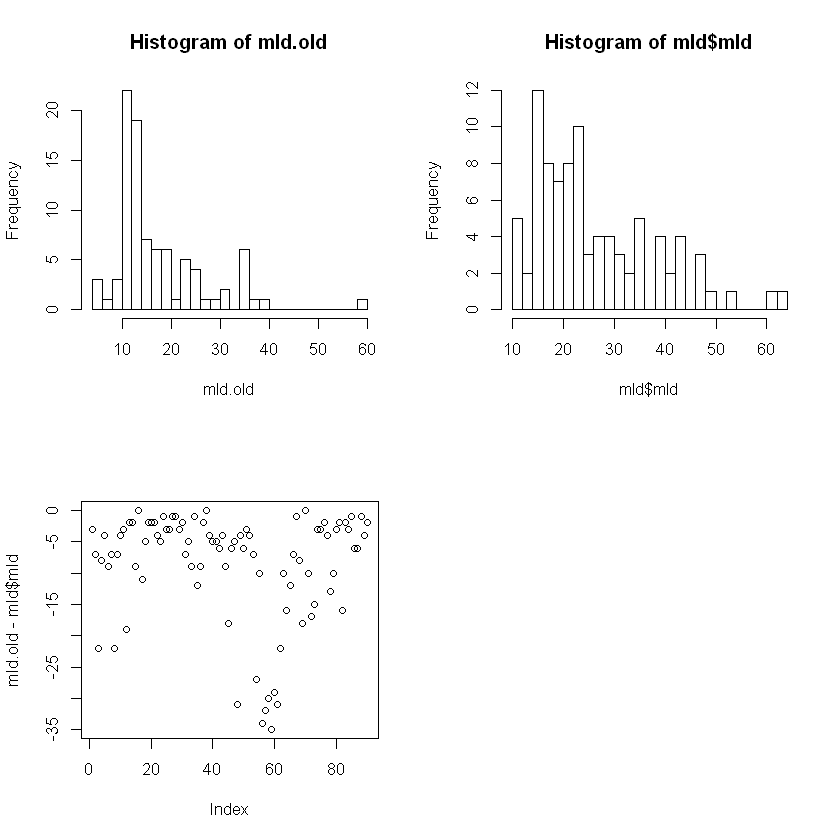

In [64]:
par(mfrow=c(2,2))
#mld.old = mld$mld
hist(mld.old, breaks = 20)
hist(mld$mld, breaks = 20)
plot(mld.old - mld$mld)

In [31]:
## Time to add the MLD variable to the main data set and interpolate
ship.data$MLD = 0

for (i in 1:nrow(ship.data)) {
    dt = abs(as.numeric(difftime(ship.data$DT[i], mld.times, units='hours')))
    dt.order = order(dt)
    
    ## Calculate the linear interpolation of the 2 closest MLD measurements
    w.1 = dt.order[1]
    if (as.numeric(difftime(ship.data$DT[i], mld.times[w.1], units='hours')) > 0) { # Shiptime is after ctd time
        w.2 = min(w.1 + 1, nrow(mld.times))
    } else {
        w.2 = max(1, w.1 - 1)
    }
    
    dt.1 = dt[w.1]
    dt.2 = dt[w.2]
    dist.1 = sqrt( (mld$Lat[w.1] - ship.data$LA[i])^2 + (mld$Long[w.1] - ship.data$LO[i])^2 )
    dist.2 = sqrt( (mld$Lat[w.2] - ship.data$LA[i])^2 + (mld$Long[w.2] - ship.data$LO[i])^2 )
    mld.1 = mld$mld[w.1]
    mld.2 = mld$mld[w.2]
    
    ## MLD is the linear interpolation from the two closest casts based on time (not distance).
    ship.data$MLD[i] = mld.1 * (dist.2 / (dist.1 + dist.2)) + mld.2 * (dist.1 / (dist.1 + dist.2))
}

In [32]:
save(ship.data, file='./RStates/ship.avg.wind.mld.rdata')
write.xlsx(ship.data, file='./Input Data/Shipdata - MLD.xlsx')
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,676470,36.2,2215351,118.4,9878615,527.6
Vcells,21202205,161.8,53275371,406.5,606368204,4626.3


---
# 4. Wind Integration
With the ship data loaded we must now interpolate the grid of the NCEP data ont othe ship's track. Here we simply do the average wind speed value for the 4 closest NCEP grid points (weighted such that the closer the grid point is the more important it is) for each track position. We then linearly interpolate this speed across the two closest times.

The 5 day intergration is done as a simple average across the 5 days prior to the current ship time using the same 4 grid point average.

Interpolations to consider
* Simple average (n points considered; quick to compute, ignorant of space or time)
* Based on distance to point (can be 2, 3, 4, or n point average)
* Bilinear (takes into account the spatial structure, likely to be identical to distance with n=4)
* Non-standard distance metric (weigths based on other than euclidean distance)
* Lienar interpolation (special case on distance with n=2, seems like the ideal for temporal interpolation)

In [ ]:
## Load the data if already present
load('./RStates/ship.avg.wind.rdata')

In [143]:
schmidt.number = function(SST) {
    
    ## Parameters of fit from Wannikhof 1992.
    a = 1953.4
    b = 128.00
    c = 3.9918
    d = 0.050091
    
    ## Calculate teh Schmidt Number
    a - b*SST + c*(SST^2) - d*(SST^3)
}

k.calc = function(u, SST) {
   # 0.31 * u^2 / sqrt(schmidt.number(SST)/660)
    0.074 * u^2 / sqrt(schmidt.number(SST)/660)  # m/d
}

#### Ventilation
##
## This function calculates the temporal length scale of the NCP measurement. Essentially it 
## calculates the ventilation based on water column and wind speed over a sequence of measurements (equally spaced).
##
##
ventilation = function(ws, mld, SST, dt) {
    weights = 1
    k.result = k.calc(ws, SST)
    
    if (length(ws) == 1) {
        return(k.result / mld)
    }
    
    #### Loop through and sequentially calculate the transfer velocities and weighting of ventilation
    ##
    for (i in 2:length(ws)) {
        ## Calculate the weighting per Reuer et al.
        f.temp = min(k.result[i-1] * dt[i] / mld, 1)
        weights[i] = weights[i-1] * (1 - f.temp)
    }
    
    #### Final Calculations
    k.final = sum(weights * k.result) / (1-weights[length(weights)])
    k.final / sum(weights) ## Normalize
}

In [148]:
## How many points to interpolate from?
N = 4
Int.t = 10 # days

## First start by creating some new variables
ship.data$NCEP = 0
#ship.data$NCEP.5 = 0
ship.data$TW.5 = 0
ship.data$k = 0


## Loop through and populate the variables one row at a time
for (i in 1:nrow(ship.data)) {
    
    #######################
    ##### Time section ####
    #######################
    
    ## Calculate the difference in time between the ship data and the NCEP times (time.actual)
    dt = abs(as.numeric(difftime(ship.data$DT[i], time.actual, units = 'days')))
    
    time.order = order(dt) # smallest 2 values are the two closest times
    time.1 = time.order[1]
    time.2 = time.order[2]
    
    ## Find the N previous days to average
    # Which days are before time i and less than N days away?
    day.5 = which(time.actual < ship.data$DT[i] & as.numeric(difftime(ship.data$DT[i], time.actual, units = 'days')) < Int.t)
    
    ## Calculate the ship N day average
    ship.5 = which(ship.data$DT < ship.data$DT[i] & as.numeric(difftime(ship.data$DT[i], ship.data$DT, units = 'days')) < Int.t)
    ship.data$TW.5[i] = mean(ship.data$TW[ship.5])
    
    #########################
    ##### Space section #####
    ##########################
    
    ## Calculate the separation betweeen the ship and NCEP grid points
    dy = (ship.data$LA[i] - wind.lat)^2
    dx = (ship.data$LO[i] - wind.lon)^2
    
    dd = dx + dy
    d.order = order(dd)
    
    ####
    ## The N closest grid points in the NCEP data will be the 1st ... N smallest dx 
    # and dy indices
    #
    # From the distance vector we will generate the weights such that sum(weights) = 1 
    # and if distance1 = 0 than weight = 1.
    ###
    
    ll = d.order[c(1:N)] # which grid cells are closest?
    dd = dd[ll] ## Calculate the distance vector
    
    ## Normalize the distance matrix if using n > 1 interpolation and transform to weights
    dd = 1 - dd / sum(dd)
    dd = dd / sum(dd)
    
    if (length(dd) == 1) { ## If N = 1 then the normalization above wont work.
        dd = 1
    }
    
    ## Calculate the wind at position for the 2 closest times
    # (NB. assumes t1 < t.ship < t2 or t2 < t.ship < t1)
    #
    wind = c(sum(wind.ncep[ll, time.1] * dd), sum(wind.ncep[ll, time.2] * dd))
     
    ## Linear interpolation with time (sum of weights = 1 and weight = 1 when dt is 0)
    ship.data$NCEP[i] = wind[1] * dt[time.2] / sum(dt[c(time.1, time.2)]) + wind[2] * dt[time.1] / sum(dt[c(time.1, time.2)])
    
    ## 5 days previous are calculated as wind1 and wind2 above but summed for each day and averaged
    wind.temp = 0
    
    for (previous.day in 1:length(day.5)) {
        wind.temp[previous.day] = sum(wind.ncep[ll, day.5[previous.day]] * dd)
    }
    
    ## Determine the time seperation between each wind measurement
    delta.t = abs(c(0, as.numeric(difftime(ship.data$DT[i], time.actual[day.5], unit='days'))))
    
    ## run the ventilation algorithm on the data.
    ship.data$k[i] = ventilation(wind.temp, ship.data$MLD[i], ship.data$TT[i], delta.t)
    
}


In [149]:
#hist(ship.data$k, breaks = 2000)
summary(ship.data$k)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.2207  0.8817  3.3647  4.0871  6.2199 12.5669      11 

In [28]:
save(ship.data, file='./RStates/ship.avg.wind.rdata')
write.xlsx(ship.data, file='./Input Data/Shipdata - Wind.xlsx')

---
# 5. Review and check data
Let's plot up some of the data now:

In [1]:
#pdf('./Output/Latest Wind.pdf')
par(mfrow=c(2,1))
plot(ship.data$DT, ship.data$TW, ylim=c(0,20), main='Ship-based Wind', xlab='', ylab='Wind Speed (m/s)', type='l')
lines(ship.data$DT, ship.data$TW.5, col='red', lwd=2)

plot(ship.data$DT, ship.data$NCEP, ylim=c(0,20), main='NCEP Data', xlab='' , ylab='Wind Speed (m/s)', type='l')
lines(ship.data$DT, ship.data$NCEP.5, col='red', lwd=2)


plot(ship.data$DT, ship.data$NCEP.5, pch=16, cex=0.2, ylim=c(0,20), main='NCEP 5-Day Average', xlab='' , ylab='Wind Speed (m/s)')
points(ship.data$DT, ship.data$TW.5, pch=16, cex=0.2, col='red')

plot(ship.data$DT, ship.data$MLD, type='l', ylab='Depth (m)', main='Mixed Layer Depth')


############################
### Plot of region       ###
############################
## Plot showing the ship's track along with the grid points in the NCEP/NCAR data set

plot(ship.data$LO, ship.data$LA, type='l', ylim=c(32,38), xlab='Longitude', ylab='Latitude')

## Add grid points
for (i in 1:length(wind.lat)) {
    points(wind.lon[i], wind.lat[i], col='red', pch=16)
}


############################
### Plot with regression ###
############################
plot(ship.data$TW, ship.data$NCEP, col='#000020', pch=16, xlab='Ship Avg Wind', ylab='NCEP Avg Wind')
model = lm(NCEP ~ TW, data = ship.data)

lines(c(1:100), predict(model, newdata = data.frame(TW = c(1:100))), col='red')
coefficients(model)
#dev.off()

ERROR: Error in plot(ship.data$DT, ship.data$TW, ylim = c(0, 20), main = "Ship-based Wind", : object 'ship.data' not found


---

# O2 Argon Data (EIMS)

In [38]:
load('./RStates/EIMS.v1.rdata')
#load('./RStates/EIMS.v2.rdata')

In [40]:
names(eims.v1)

[1] "cycle.."      "time"         "X18.03"       "X28.03"       "X32"         
 [6] "X40"          "X44.06"       "X45.06"       "TP"           "N2.Ar"       
[11] "O2.Ar"        "N2.O2"        "Valve"        "ID"           "S."          
[16] "O2..uM."      "O2.Sat...."   "Temp..C."     "Calphase..C." "TCphase..C." 
[21] "C1..C."       "C2..C."       "C1amp..mV."   "C2amp..mV."   "Temp..mV."   
[26] "inlet"        "sock"         "outlet"       "MS"           "flow"

In [41]:
avg.length = 10

ship.data$O2.Ar = 0
ship.data$O2.Sat = 0
ship.data$Inlet.T = 0

for (i in 1:nrow(ship.data)) {
    dt = abs(as.numeric(difftime(ship.data$DT[i], eims.v1$time, unit='mins')))
    
    l = which(dt > -avg.length/2 & dt < avg.length/2)
    
    ship.data$O2.Ar[i] = mean(eims.v1$O2.Ar[l])
    ship.data$O2.Sat[i] = mean(eims.v1$O2.Sat....[l])
    ship.data$Inlet.T[i] = mean(eims.v1$inlet[l])
}


In [44]:
## constants for Schmidt number calculation (Wanninkhof, 1992)
Schmidta = 1953.4
Schmidtb = 128.00
Schmidtc = 3.9918
Schmidtd = 0.050091
sc = Schmidta - Schmidtb*ship.data$TT + Schmidtc* (ship.data$TT^2) - Schmidtd* (ship.data$TT^3)

#quadratic relationship (Equation 3 of Wanninkhov 1992)

pvmat = 0.074 * (ship.data$NCEP^2) * ((ship.data$NCEP/660)^-0.5) # units of m/d
#elseif alg_id == 2
#    pvmat = 0.0068.*(ws.^3).*((scmat/660).^-0.5); % units of m/d
#elseif alg_id == 3
#    pvmat = 0.061.*(ws.^2).*((scmat/660).^-0.5); % units of m/d
#elseif alg_id == 4
#    pvmat = (0.053.*(ws.^2)+0.024.*ws).*((scmat/660).^-0.5); % units of m/d
#elseif alg_id == 5
#    pvmat = 0.065.*(ws.^2).*((scmat/660).^-0.5); % units of m/d



In [47]:
O2sol = function(S, T) {
# convert T to scaled temperature
temp_S = log((298.15 - T) / (273.15 + T))

# constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
A0_o2 = 5.80871
A1_o2 = 3.20291
A2_o2 = 4.17887
A3_o2 = 5.10006
A4_o2 = -9.86643e-2
A5_o2 = 3.80369
B0_o2 = -7.01577e-3
B1_o2 = -7.70028e-3
B2_o2 = -1.13864e-2
B3_o2 = -9.51519e-3
C0_o2 = -2.75915e-7

# Corrected Eqn (8) of Garcia and Gordon 1992 (umol / kg)
exp(A0_o2 + A1_o2*temp_S + A2_o2*temp_S^2 + A3_o2*temp_S^3 + 
              A4_o2*temp_S^4 + A5_o2*temp_S^5 + S*(B0_o2 + B1_o2*temp_S + 
                                                   B2_o2*temp_S^2 + B3_o2*temp_S^3) + C0_o2*S^2)
}

In [155]:
## calculating NCP from O2/Ar
# NCP in mmol m-2 d-1; seawater density in kg m-3, O2sol in microL kg-1
#ncp = (ship.data$O2.Ar/100) * (O2sol(ship.data$SA, ship.data$TT) / 1000) * ship.data$sw_dens0(salt, temp) * wpv;
ncp = (ship.data$O2.Ar/25 - 1) * (O2sol(ship.data$SA, ship.data$TT) / 1000) * 1030 * ship.data$k

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.6708  4.0047  7.6632  7.1581 10.3273 13.2232      11 

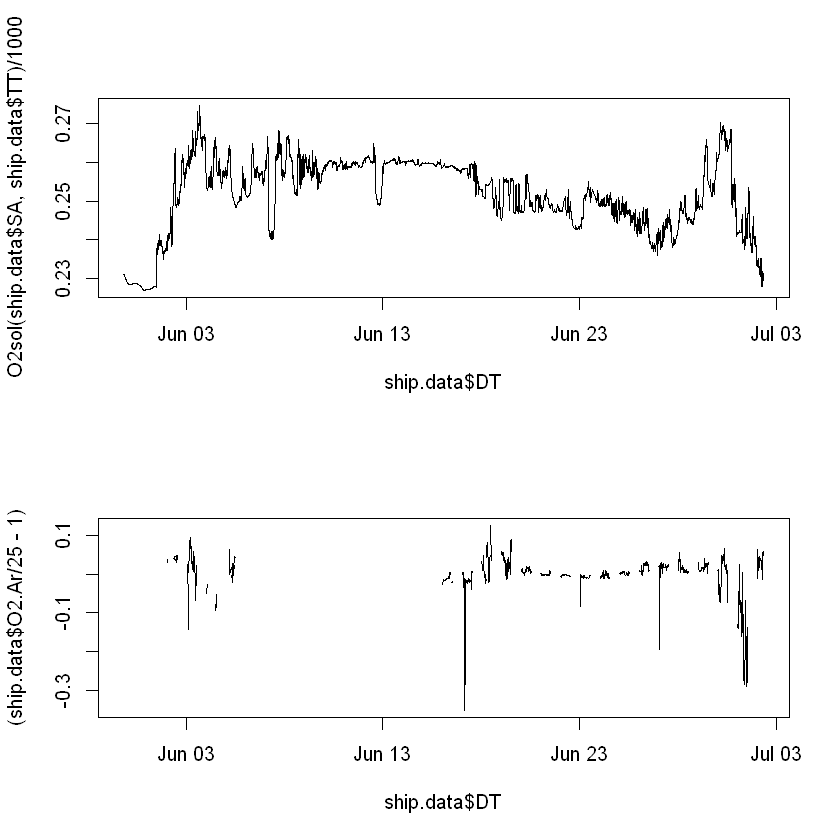

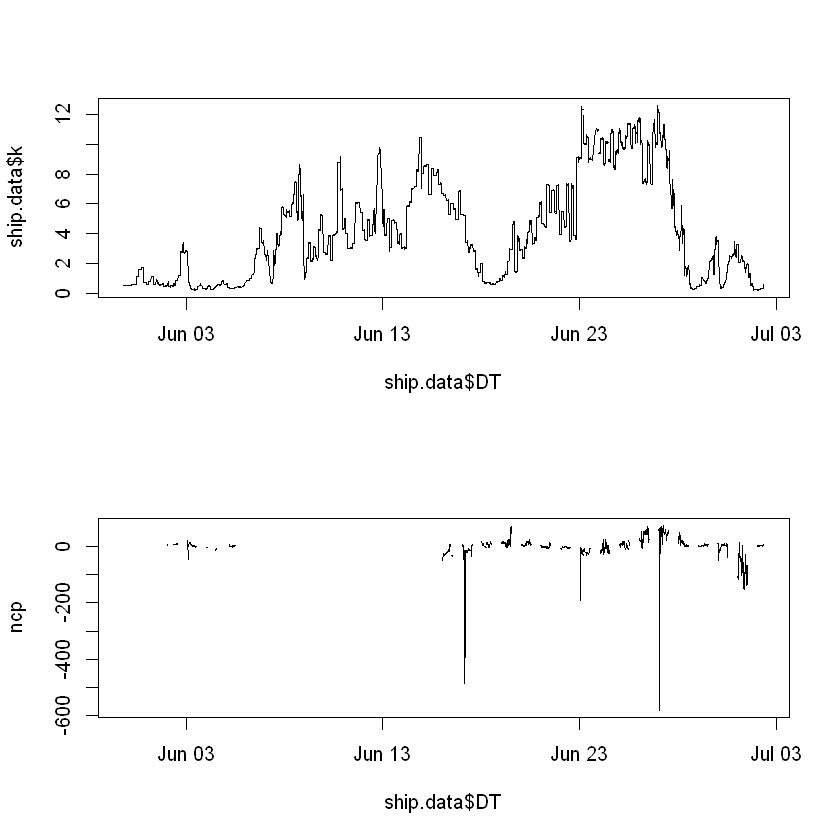

In [156]:
par(mfrow=c(2,1))

summary(ship.data$NCEP)
plot(ship.data$DT, O2sol(ship.data$SA, ship.data$TT) / 1000, type='l')
plot(ship.data$DT,  (ship.data$O2.Ar/25 - 1), type='l')
plot(ship.data$DT, ship.data$k, type='l')
plot(ship.data$DT, ncp, type='l')